In [1]:
%matplotlib inline
import os
os.chdir('U:\\GitHubClones\\SALTSeniorDesign')
os.getcwd()
#import Excel
import xlwings as xw
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import re
from datetime import datetime
import datetime
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import preprocessing
import time

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
mapDict = {
    'subvented':{
        0:'None',
        1:'Rate',
        2:'Cash',
        3:'Both',
    },
    'vehicleTypeCode':{
        1:'Car',
        2:'Truck',
        3:'SUV',
        4:'Motorcycle',
        98:'Other',
        99:'Unknown'
    },
    'obligorIncomeVerificationLevelCode':{
        1:'NotStatedNotVerified',
        2:'StatedNotVerified',
        3:'StatedVerified',
        4:'Stated12mVerified',
        5:'Stated24mVerified'
    },
    'obligorEmploymentVerificationCode':{
        1:'NotStatedNotVerified',
        2:'StatedNotVerified',
        3:'StatedVerified'
    }
}

'''
x = list(Dict.keys())
for i in range(0, len(x)):
    data[x[i]] = data[x[i]].map(Dict[x[i]])
data = pd.get_dummies(data, columns= x)
'''
#For creating dummy variables on the fly

'\nx = list(Dict.keys())\nfor i in range(0, len(x)):\n    data[x[i]] = data[x[i]].map(Dict[x[i]])\ndata = pd.get_dummies(data, columns= x)\n'

In [4]:
cols = ['assetNumber', 'reportingPeriodEndingDate','reportingPeriodBeginningDate',
        'originalLoanTerm','originalLoanAmount','vehicleValueAmount','originalInterestRatePercentage','subvented',
        'vehicleNewUsedCode', 'vehicleModelYear','vehicleTypeCode',
        'obligorCreditScore','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode','obligorGeographicLocation',
        'paymentToIncomePercentage', 'reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid',
        'remainingTermToMaturityNumber',
        'currentDelinquencyStatus','coObligorIndicator',
        'zeroBalanceCode']

logitRemoveCols = ['assetNumber', 'reportingPeriodEndingDate','originalLoanAmount','vehicleValueAmount','reportingPeriodActualEndBalanceAmount',
        'reportingPeriodBeginningLoanBalanceAmount','totalActualAmountPaid','vehicleNewUsedCode','zeroBalanceCode',
        'vehicleModelYear','currentDelinquencyStatus','subvented','obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode',
        'obligorGeographicLocation','reportingPeriodBeginningDate']

In [5]:
wb = xw.Book('Salt.xlsm')
setup = wb.sheets('Setup')
output = wb.sheets('Output')
strats = wb.sheets('Strat Tables')
performance = wb.sheets('Performance')

# Path For the Current deal that is selected based on Setup
directory = setup['Setup.Directory'].value
shelf = setup['Setup.Shelf'].value
deal = setup['Setup.Deal'].value
report = setup['Setup.Report'].value
num_Deals = setup['Setup.Num_Deals'].value
max_Report = setup['Setup.Max_Report_Num'].value

In [6]:
tapes = np.array(setup['Tapes'].value)
tapes = tapes[0:int(max_Report),0:int(num_Deals)]
dfTapes = pd.DataFrame(data=tapes[1:,1:], columns=tapes[0,1:])
dfTapes

,AMCAR 2017-1,AMCAR 2017-2,AMCAR 2017-3,DRIVE 2017-1,DRIVE 2017-2,DRIVE 2017-3,SDART 2017-1,SDART 2017-2,SDART 2017-3
0,2017\01 January\2017.03.23_AmeriCredit Automob...,2017\03 March\2017.05.02_AmeriCredit Automobil...,2017\06 June\2017.07.01_AmeriCredit Automobile...,2017\05 May\2017.06.15_Drive Auto Receivables ...,2017\06 June\2017.07.20_Drive Auto Receivables...,2017\09 September\2017.10.11_Drive Auto Receiv...,2017\01 January\2017.02.15_Santander Drive Aut...,2017\04 April\2017.05.18_Santander Drive Auto ...,2017\08 August\2017.09.07_Santander Drive Auto...
1,2017\02 February\2017.03.23_AmeriCredit Automo...,2017\04 April\2017.06.23_AmeriCredit Automobil...,2017\07 July\2017.08.25_AmeriCredit Automobile...,2017\06 June\2017.07.17_Drive Auto Receivables...,2017\07 July\2017.08.15_Drive Auto Receivables...,2017\10 October\2017.11.15_Drive Auto Receivab...,2017\02 February\2017.03.15_Santander Drive Au...,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\09 September\2017.10.16_Santander Drive A...
2,2017\03 March\2017.04.24_AmeriCredit Automobil...,2017\05 May\2017.07.24_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,2017\07 July\2017.08.15_Drive Auto Receivables...,2017\08 August\2017.09.15_Drive Auto Receivabl...,None,2017\03 March\2017.04.17_Santander Drive Auto ...,2017\06 June\2017.07.17_Santander Drive Auto R...,None
3,2017\04 April\2017.05.23_AmeriCredit Automobil...,2017\06 June\2017.08.23_AmeriCredit Automobile...,None,2017\08 August\2017.09.15_Drive Auto Receivabl...,2017\09 September\2017.10.16_Drive Auto Receiv...,None,2017\04 April\2017.05.15_Santander Drive Auto ...,2017\07 July\2017.08.15_Santander Drive Auto R...,None
4,2017\05 May\2017.06.23_AmeriCredit Automobile ...,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,2017\09 September\2017.10.16_Drive Auto Receiv...,2017\10 October\2017.11.15_Drive Auto Receivab...,None,2017\05 May\2017.06.15_Santander Drive Auto Re...,2017\08 August\2017.09.15_Santander Drive Auto...,None
5,2017\06 June\2017.07.24_AmeriCredit Automobile...,2017\10 October\2017.11.22_AmeriCredit Automob...,None,2017\10 October\2017.11.15_Drive Auto Receivab...,None,None,2017\06 June\2017.07.17_Santander Drive Auto R...,2017\09 September\2017.10.16_Santander Drive A...,None
6,2017\07 July\2017.08.23_AmeriCredit Automobile...,None,None,None,None,None,2017\07 July\2017.08.15_Santander Drive Auto R...,2017\10 October\2017.11.15_Santander Drive Aut...,None
7,2017\08 August\2017.09.25_AmeriCredit Automobi...,None,None,None,None,None,2017\08 August\2017.09.15_Santander Drive Auto...,None,None
8,2017\10 October\2017.11.22_AmeriCredit Automob...,None,None,None,None,None,2017\09 September\2017.10.16_Santander Drive A...,None,None


In [7]:
def chargeOffs(tapes, deal, unemploymentPath):
    dealList = list(tapes[deal].astype(str))
    dealList = list(filter(lambda a: a != 'None', dealList))
    train = pd.DataFrame()
    for i in range(0, len(dealList)):
        path = directory + '\\' + shelf + '\\' + deal + '\\' + dealList[i]
        df = pd.read_csv(path, usecols=cols, memory_map=True, low_memory=False)
        df = df[~df.zeroBalanceCode.isin(['-'])]#taking out all of the performing loans so far
        
        df['LTV'] = (df['originalLoanAmount']/df['vehicleValueAmount'])*100
        df['loanDiff'] = (df['originalLoanAmount'] - df['reportingPeriodBeginningLoanBalanceAmount'])
        df['coObligorIndicator'] = df['coObligorIndicator'].astype(int)
        
        umrate = pd.read_csv(unemploymentPath, memory_map=True, low_memory=False)
        umrate['Date'] = pd.to_datetime(umrate.Date)
        umrate['Date'] = umrate['Date'].dt.strftime('%m/%d/%Y')
        umrate = umrate.set_index('Date')
        stateDict = umrate.to_dict(orient='index')

        df['reportingPeriodBeginningDate'] = pd.to_datetime(df['reportingPeriodBeginningDate']).dt.strftime('%m/%d/%Y')
        states = list(df['obligorGeographicLocation'])
        uniqueList = df.reportingPeriodBeginningDate.unique()
        umList = []
        for j in range(0, len(states)):
            if not uniqueList[0]:
                continue
            val = stateDict[uniqueList[0]].get(states[j])
            umList.append(val)
        unemployment = pd.Series(umList)
        df = df.assign(StateUnemployment=unemployment.values)
        train = train.append(df)
    
    
    return train

In [8]:
umRatePath = 'U:\\GitHubClones\\SALTSeniorDesign\\' + 'State_level_unemployment_rate.csv'
dfTrain = chargeOffs(dfTapes, deal, umRatePath)

In [11]:
dfTrain.head()

,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originalLoanAmount,originalLoanTerm,originalInterestRatePercentage,subvented,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,remainingTermToMaturityNumber,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,totalActualAmountPaid,zeroBalanceCode,currentDelinquencyStatus,LTV,loanDiff,StateUnemployment
186,"=""10421638""",02/01/2017,02-28-2017,25757.50,72,0.1529,0,2,2012,2,21650.0,568,2,2,1,0.091469,TX,43,18154.76,0.0,18413.33,1,0,118.972286,7602.74,4.9
191,"=""10421038""",02/01/2017,02-28-2017,17365.00,72,0.1800,0,2,2013,1,15925.0,505,2,1,0,0.181373,VT,43,12567.27,0.0,12740.80,1,0,109.042386,4797.73,3.0
245,"=""10630614""",02/01/2017,02-28-2017,15088.99,72,0.2133,0,2,2013,1,14625.0,533,2,1,0,0.167298,OH,43,11231.34,0.0,11505.89,1,0,103.172581,3857.65,5.1
283,"=""10629606""",02/01/2017,02-28-2017,29188.00,72,0.1672,0,2,2013,1,20875.0,593,2,2,0,0.123994,TX,42,20059.38,0.0,20454.50,1,0,139.822754,9128.62,4.9
394,"=""10646660""",02/01/2017,02-28-2017,21360.45,72,0.1678,1,1,2014,2,45761.0,-,2,2,0,0.047583,FL,43,15290.40,0.0,15522.13,1,0,46.678285,6070.05,5.0


In [9]:
def clean(data):
    data['obligorCreditScore'] = data['obligorCreditScore'].replace(['-'], 0)
    data['zeroBalanceCode'] = pd.to_numeric(data['zeroBalanceCode'], errors = 'coerce')
    data['obligorCreditScore'] = pd.to_numeric(data['obligorCreditScore'], errors = 'coerce')
    data['subvented'] = pd.to_numeric(data['subvented'], errors = 'coerce').fillna(3)
    return data

def logitDummyVariables(data):
    
    data['newUsed'] = np.where((data['vehicleNewUsedCode']>1), 1, 0) # 0 means new, 1 means used
    data['subvent'] = np.where((data['subvented']>0), 1, 0)
    data['verifyScore'] = data['obligorIncomeVerificationLevelCode'] + data['obligorEmploymentVerificationCode']
    data['Default'] = np.where((data['zeroBalanceCode'] == 4), 1, 0)
    
    return data

In [10]:
dfTrain = clean(dfTrain)
dfTrain = logitDummyVariables(dfTrain)
dfTrain = dfTrain.drop(logitRemoveCols, axis=1)
dfTrain.head()

,originalLoanTerm,originalInterestRatePercentage,vehicleTypeCode,obligorCreditScore,coObligorIndicator,paymentToIncomePercentage,remainingTermToMaturityNumber,LTV,loanDiff,StateUnemployment,newUsed,subvent,verifyScore,Default
186,72,0.1529,2,568,1,0.091469,43,118.972286,7602.74,4.9,1,0,4,0
191,72,0.1800,1,505,0,0.181373,43,109.042386,4797.73,3.0,1,0,3,0
245,72,0.2133,1,533,0,0.167298,43,103.172581,3857.65,5.1,1,0,3,0
283,72,0.1672,1,593,0,0.123994,42,139.822754,9128.62,4.9,1,0,4,0
394,72,0.1678,2,0,0,0.047583,43,46.678285,6070.05,5.0,0,1,4,0


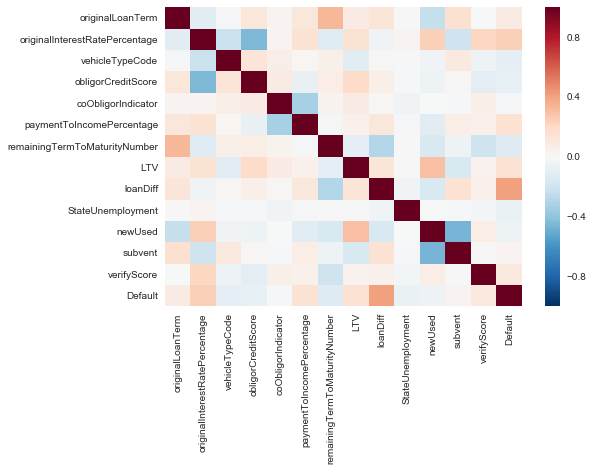

In [11]:
sb.heatmap(dfTrain.corr())

In [12]:
modelCols = list(dfTrain.columns)
modelCols = modelCols[:-1]
predictors = dfTrain[modelCols]
y = dfTrain.Default

In [16]:
est = sm.OLS(y, predictors).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Default   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     1333.
Date:                Thu, 30 Nov 2017   Prob (F-statistic):               0.00
Time:                        10:03:21   Log-Likelihood:                -7391.2
No. Observations:               12966   AIC:                         1.481e+04
Df Residuals:                   12953   BIC:                         1.491e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0007      0.001     -1.441      0.149      -0.002       0.000
originalInterestRatePercentage     2.4685      0.100     24.583      0.000       2.272       2.665
vehicleTypeCode                   -0.0329      0.005     -7.147      0.000      -0.042      -0.024
obligorCreditScore             -3.279e-05   1.85e-05     -1.776      0.076    -6.9e-05    3.39e-06
coObligorIndicator                -0.0124      0.009     -1.383      0.167      -0.030       0.005
paymentToIncomePercentage          0.5762      0.103      5.593      0.000       0.374       0.778
remainingTermToMaturityNumber      0.0003      0.000      1.283      0.200      -0.000       0.001
LTV                                0.0017      0.000      7.502      0.000       0.001       0.002
loanDiff                        2.028e-05   4.33e-07     46.806      0.000    1.94e-05    2.11e-05
StateUnemployment                 -0.0634      0.005    -12.220      0.000      -0.074      -0.053
newUsed                           -0.0754      0.010     -7.374      0.000      -0.095      -0.055
subvent                           -0.0143      0.016     -0.910      0.363      -0.045       0.017
verifyScore                        0.0024      0.005      0.443      0.658      -0.008       0.013
==============================================================================
Omnibus:                     3630.816   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.517
Skew:                           0.265   Prob(JB):                    4.71e-158
Kurtosis:                       1.971   Cond. No.                     3.88e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
logReg = sm.Logit(y,predictors).fit()
logReg.summary()

Optimization terminated successfully.
         Current function value: 0.547534
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                12966
Model:                          Logit   Df Residuals:                    12953
Method:                           MLE   Df Model:                           12
Date:                Mon, 04 Dec 2017   Pseudo R-squ.:                  0.1980
Time:                        12:03:08   Log-Likelihood:                -7099.3
converged:                       True   LL-Null:                       -8852.3
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
originalLoanTerm                  -0.0207      0.003     -7.569      0.000      -0.026      -0.015
originalInterestRatePercentage    12.3450      0.573     21.549      0.000      11.222      13.468
vehicleTypeCode                   -0.2305      0.026     -8.954      0.000      -0.281      -0.180
obligorCreditScore                -0.0002   9.74e-05     -2.428      0.015      -0.000   -4.56e-05
coObligorIndicator                -0.0558      0.049     -1.132      0.257      -0.152       0.041
paymentToIncomePercentage          3.2145      0.562      5.717      0.000       2.112       4.317
remainingTermToMaturityNumber      0.0013      0.001      1.083      0.279      -0.001       0.004
LTV                                0.0084      0.001      6.686      0.000       0.006       0.011
loanDiff                           0.0001   2.65e-06     39.070      0.000    9.84e-05       0.000
StateUnemployment                 -0.4657      0.029    -16.166      0.000      -0.522      -0.409
newUsed                           -0.5188      0.057     -9.067      0.000      -0.631      -0.407
subvent                           -0.1320      0.090     -1.464      0.143      -0.309       0.045
verifyScore                       -0.0934      0.028     -3.290      0.001      -0.149      -0.038
==================================================================================================
"""

In [14]:
logReg.conf_int()

,0,1
originalLoanTerm,-0.026099,-0.015362
originalInterestRatePercentage,11.222193,13.467871
vehicleTypeCode,-0.281011,-0.180080
obligorCreditScore,-0.000428,-0.000046
coObligorIndicator,-0.152323,0.040764
paymentToIncomePercentage,2.112409,4.316662
remainingTermToMaturityNumber,-0.001060,0.003676
LTV,0.005909,0.010810
loanDiff,0.000098,0.000109
StateUnemployment,-0.522126,-0.409213


In [16]:
np.exp(logReg.params).to_clipboard()

In [19]:
del dfTrain

In [29]:
dfForest = chargeOffs(dfTapes, deal, umRatePath)
dfForest = clean(dfForest)
dfForest.head()

,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originalLoanAmount,originalLoanTerm,originalInterestRatePercentage,subvented,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,remainingTermToMaturityNumber,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,totalActualAmountPaid,zeroBalanceCode,currentDelinquencyStatus,LTV,loanDiff,StateUnemployment
186,"=""10421638""",02/01/2017,02-28-2017,25757.50,72,0.1529,0.0,2,2012,2,21650.0,568,2,2,1,0.091469,TX,43,18154.76,0.0,18413.33,1,0,118.972286,7602.74,4.9
191,"=""10421038""",02/01/2017,02-28-2017,17365.00,72,0.1800,0.0,2,2013,1,15925.0,505,2,1,0,0.181373,VT,43,12567.27,0.0,12740.80,1,0,109.042386,4797.73,3.0
245,"=""10630614""",02/01/2017,02-28-2017,15088.99,72,0.2133,0.0,2,2013,1,14625.0,533,2,1,0,0.167298,OH,43,11231.34,0.0,11505.89,1,0,103.172581,3857.65,5.1
283,"=""10629606""",02/01/2017,02-28-2017,29188.00,72,0.1672,0.0,2,2013,1,20875.0,593,2,2,0,0.123994,TX,42,20059.38,0.0,20454.50,1,0,139.822754,9128.62,4.9
394,"=""10646660""",02/01/2017,02-28-2017,21360.45,72,0.1678,1.0,1,2014,2,45761.0,0,2,2,0,0.047583,FL,43,15290.40,0.0,15522.13,1,0,46.678285,6070.05,5.0


In [30]:
MlRemoveCols = ['obligorGeographicLocation','assetNumber', 'reportingPeriodBeginningDate', 'reportingPeriodEndingDate']
dfForest = dfForest.drop(MlRemoveCols, axis=1)

In [50]:
len(dfForest.index)

12966

In [34]:
dfForest_scale = preprocessing.StandardScaler().fit_transform(dfForest)

In [48]:
sklearn_pca = PCA().fit_transform(dfForest_scale)
sklearn_pca[0]

array([  1.39513605e+00,  -1.27222614e+00,   9.04328577e-01,
        -1.05556670e+00,  -8.92796877e-01,   2.36785830e-01,
        -9.75276928e-02,   1.04013875e+00,   6.76791076e-01,
        -6.32070306e-01,  -3.30611550e-02,   1.68251911e-01,
        -2.95054924e-01,   2.54296640e-01,   3.89666852e-01,
        -3.43089084e-01,  -1.55560067e-01,  -2.73716979e-01,
         1.23116426e-02,  -7.75337954e-02,   4.45334235e-14,
         8.69436442e-19])

In [52]:
dfPCA = pd.DataFrame(sklearn_pca, columns=dfForest.columns)
dfPCA.head()

,originalLoanAmount,originalLoanTerm,originalInterestRatePercentage,subvented,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,remainingTermToMaturityNumber,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,totalActualAmountPaid,zeroBalanceCode,currentDelinquencyStatus,LTV,loanDiff,StateUnemployment
0,1.395136,-1.272226,0.904329,-1.055567,-0.892797,0.236786,-0.097528,1.040139,0.676791,-0.632070,-0.033061,0.168252,-0.295055,0.254297,0.389667,-0.343089,-0.155560,-0.273717,0.012312,-0.077534,4.453342e-14,8.694364e-19
1,0.438782,-1.044674,-1.271571,-0.641917,0.885381,-1.649643,0.520548,-2.197886,1.258276,-1.066917,-0.275311,0.494983,-1.153979,0.296244,0.193077,1.340226,0.240903,-0.504984,0.079792,-0.025914,-1.072931e-15,-1.771785e-17
2,0.150149,-1.392646,-1.547606,-0.345912,1.087676,-1.644570,-0.935503,0.555760,0.706962,-0.539802,0.056256,0.563827,-1.480285,0.283770,-0.279881,1.233611,0.204436,-0.563520,0.097363,-0.039922,4.457659e-16,-7.892603e-18
3,1.239149,-0.963603,0.383842,-0.624037,-0.850145,-1.859902,-1.184688,0.284491,0.541461,-0.593084,-0.676210,-0.045406,0.690485,0.036879,-0.080335,-0.091929,-0.083136,-0.500344,-0.001055,-0.068210,1.874163e-15,-9.628563e-19
4,3.142759,0.414238,0.993939,1.601475,4.068513,2.047566,-0.369050,1.126468,0.498264,-0.423521,0.041097,-1.995573,-0.202036,0.137993,-0.731173,-0.263076,0.254668,-0.066386,0.040670,1.080489,1.316221e-15,3.816021e-18


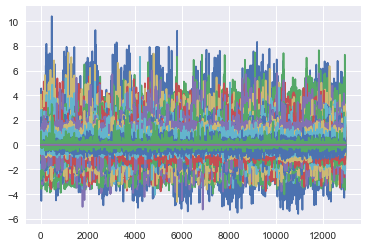

In [53]:
plt.plot(dfPCA)

In [20]:
dfForest.zeroBalanceCode.unique()

array([1, 4, 3], dtype=int64)